# 0.0. IMPORTS

In [1]:
# Importando pandas e a classe inflection (para organizar os nomes das colunas)
# Importando também numpy para tratar números, seaborn e matplotlib para visualization
%matplotlib inline
import matplotlib.pyplot as plt
import pandas  as pd
import numpy   as np
import seaborn as sns

import math
import inflection

from IPython.core.display import HTML

# Corrigir o tamanho dos gráficos pequenos
plt.rcParams['figure.figsize'] = [30, 20]

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
# Lendo os arquivos CSV utilizando parametro low_memory que ajuda PC's com baixa memória a carregar grandes arquivos
# Se low_memory = False, então ele irá carregar todo o arquivo de uma vez, do contrário carregaria em partes
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Juntando os dois DF's, utilizando "left join" e a coluna "Store" como PK, esta coluna está presente em ambos DF's

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DESCRICAO DOS DADOS

In [3]:
#Criando um DF de cópia de segurança
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
# Guardando as antigas colunas em uma variável para trata-las posteriormente

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# utilizando uma função snakecase que chama a função lambda para chamar o inflection e transformar as colunas em minusculo
# separado por underline _

snakecase = lambda x: inflection.underscore( x )


# função map mapeia tudo da snakecase e pega a lista cols_old guardando a nova lista na variável cols_new
cols_new = list( map( snakecase, cols_old ) )

# passando as colunas cols_new para o DF1
df1.columns =  cols_new

## 1.2. Data Dimensions

In [5]:
# Apenas printa a quantidade de linhas e coluna do DF
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [6]:
# Tipos de dados em cada coluna do DF
# Observando a coluna Date que é um Object (Object = string no pandas, tudo que não for INT o pandas transforma em Object)
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [7]:
# Utilizando a função to_datetime para converter a coluna date para datetime
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [8]:
# Checando se possui alguma coluna com linha vazia e somando o total em cada coluna

# existem 3 formas de tratar NA
#   1- Eliminar as linhas que possuem NA
#   2- Usar algoritmo de ML para completar esses NA
#   3- Entendendo do negócio para saber o motivo das linhas estarem faltando

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
## aplicando função lambda para aplicar um valor em tudo que é NA e deixar o valor atual nos que possuem algum valor
## Foi feito desta forma pois considera-se que se o concorrente está muito longe, não existe concorrencia, então
## colocou-se um valor muito grande (maior que o máximo existente)
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

## aplicando novamente a função lambda para transferir o valor da coluna date para a as colunas da data de abertura
## dos concorrentes, assim os algoritmos de ML podem utilizar a função para calcular tempos de datas
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

## Mesma lógica do competition_open_since_year, aplicando a data nas linhas NA para poder abastecer futuramente
## os algoritmos de ML
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )


## Foi criado um dicionario com os meses, transformando as linhas com NA em 0, inserindo o nome do mês na nova coluna
## chamada month_map de acordo com o nome especificado no dicionário e usando a função lambada, passamos pelas linhas
## inserindo 1 quando o mes da coluna date estiver presente na coluna promo_interval e 0 caso não tenha o mês
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True)
             
df1['month_map'] = df1['date'].dt.month.map( month_map )
             
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

In [10]:
# 5 exemplos exibindo em Tabela
df1.sample(5).T

,393883,238778,85171,400190,645983
store,505,631,432,229,69
day_of_week,3,1,6,3,5
date,2014-07-16 00:00:00,2014-12-29 00:00:00,2015-05-16 00:00:00,2014-07-09 00:00:00,2013-11-29 00:00:00
sales,5850,5688,8800,5659,15402
customers,610,684,1043,591,1878
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,a,d,a,d,c


In [11]:
#Total de NA ou NaN em cada coluna
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [12]:
#Conferindo novamente os tipos de cada coluna
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
# Convertendo as colunas que estão em float (decimal) para int64 assim como o restante do DF

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( "int64" )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( "int64" )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( "int64" )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( "int64" )

In [14]:
# Checando se as conversões foram feitas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [16]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
652306,817,7,0,0,0,0,0,140.0,3,2006,0,47,2013,0
360346,656,4,3858,376,1,1,1,410.0,4,2009,1,13,2010,0
395929,724,1,8097,774,1,1,1,5900.0,7,2014,0,29,2014,0
831681,677,7,0,0,0,0,0,1740.0,6,2014,1,45,2009,0
1015609,630,3,6700,846,1,0,1,1690.0,4,2015,0,1,2013,0


In [17]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
1010020,0,a,c,"Mar,Jun,Sept,Dec",Jan
140502,0,d,a,"Feb,May,Aug,Nov",Mar
651832,0,d,a,"Jan,Apr,Jul,Oct",Nov
20259,0,a,a,"Jan,Apr,Jul,Oct",Jul
407444,0,d,c,"Jan,Apr,Jul,Oct",Jul


### 1.7.1. Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [19]:
# min = valor mínimo da coluna
# max = valor máximo da coluna
# range = diferença entre mínimo e máximo
# mean = MÉDIA da coluna
# median = 
# std = desvio padrão, pode ser interpretada como margem de erro, std = 100 de uma mean = 300 significa que o valor é entre 200 a 400
# skew = 
# kurtosis = 

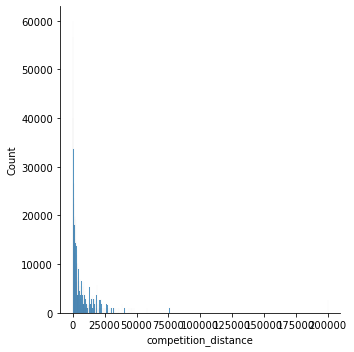

In [20]:
sns.displot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [21]:
# Pegar quantidade de valores únicos em cada coluna
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

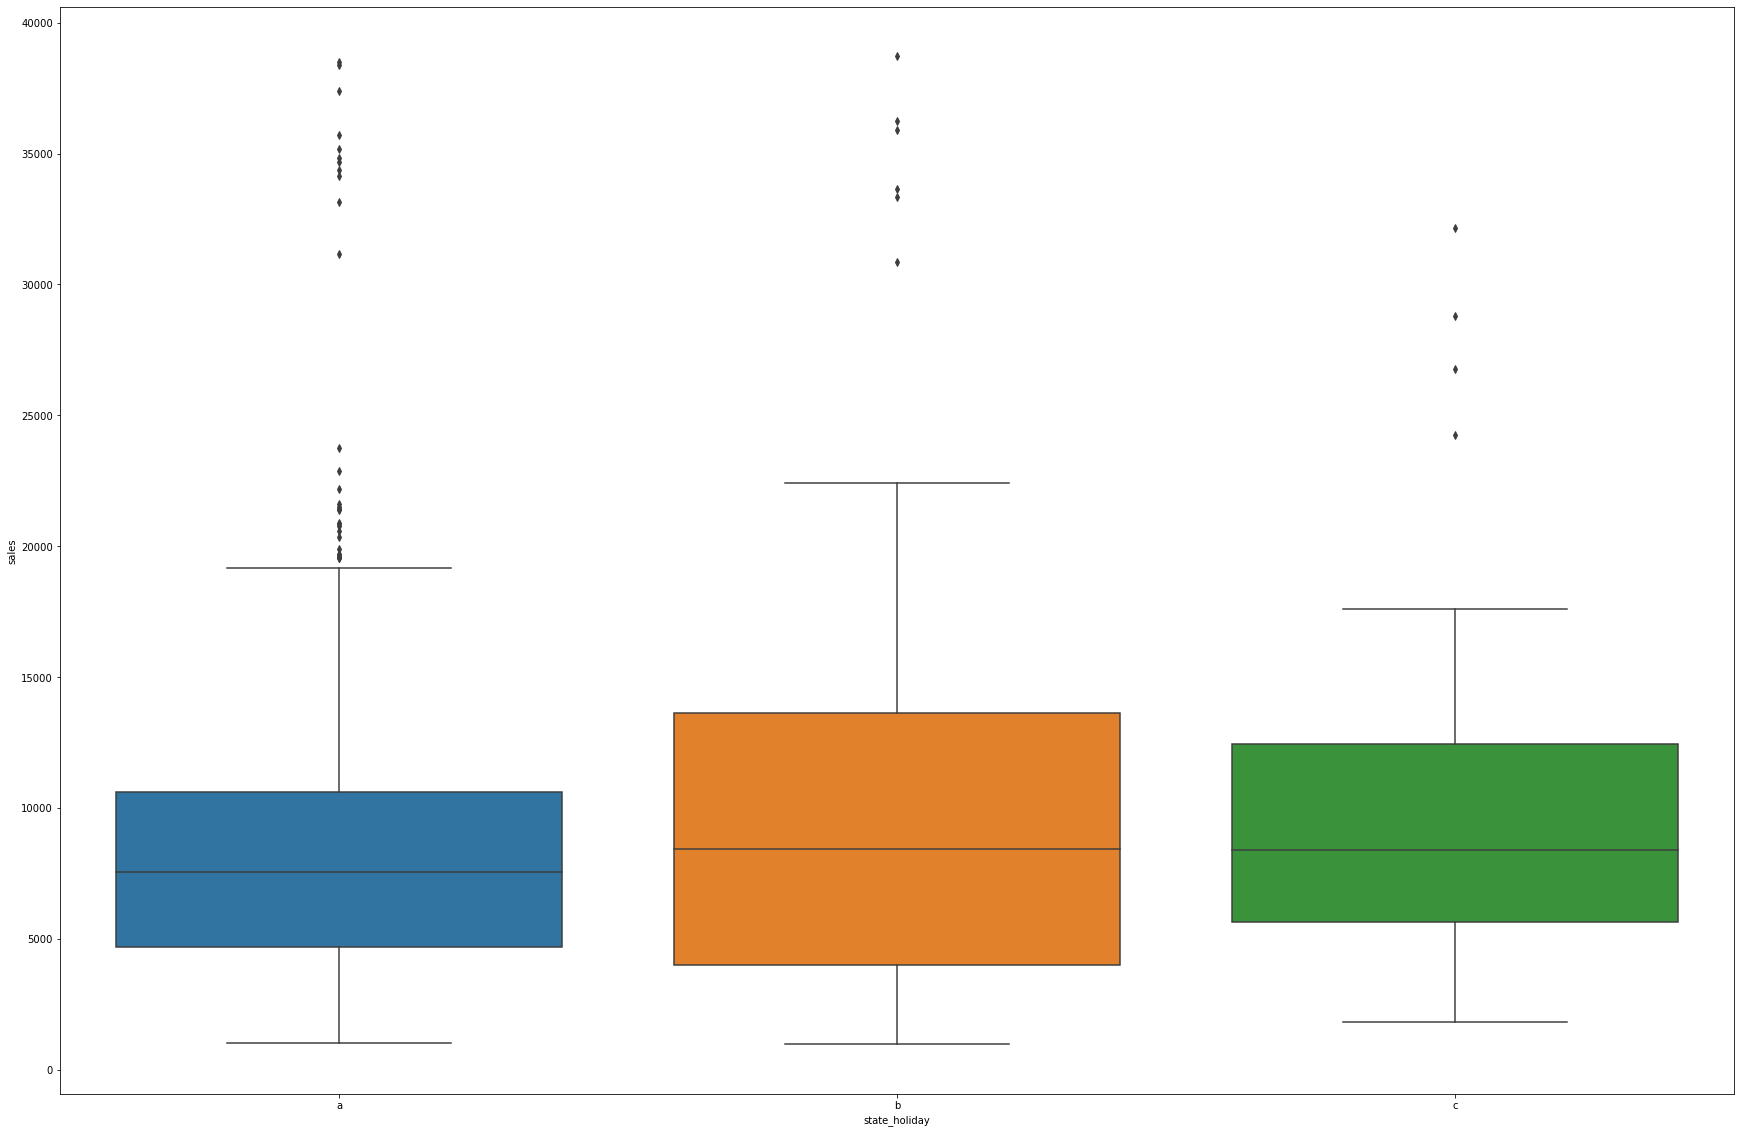

In [22]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

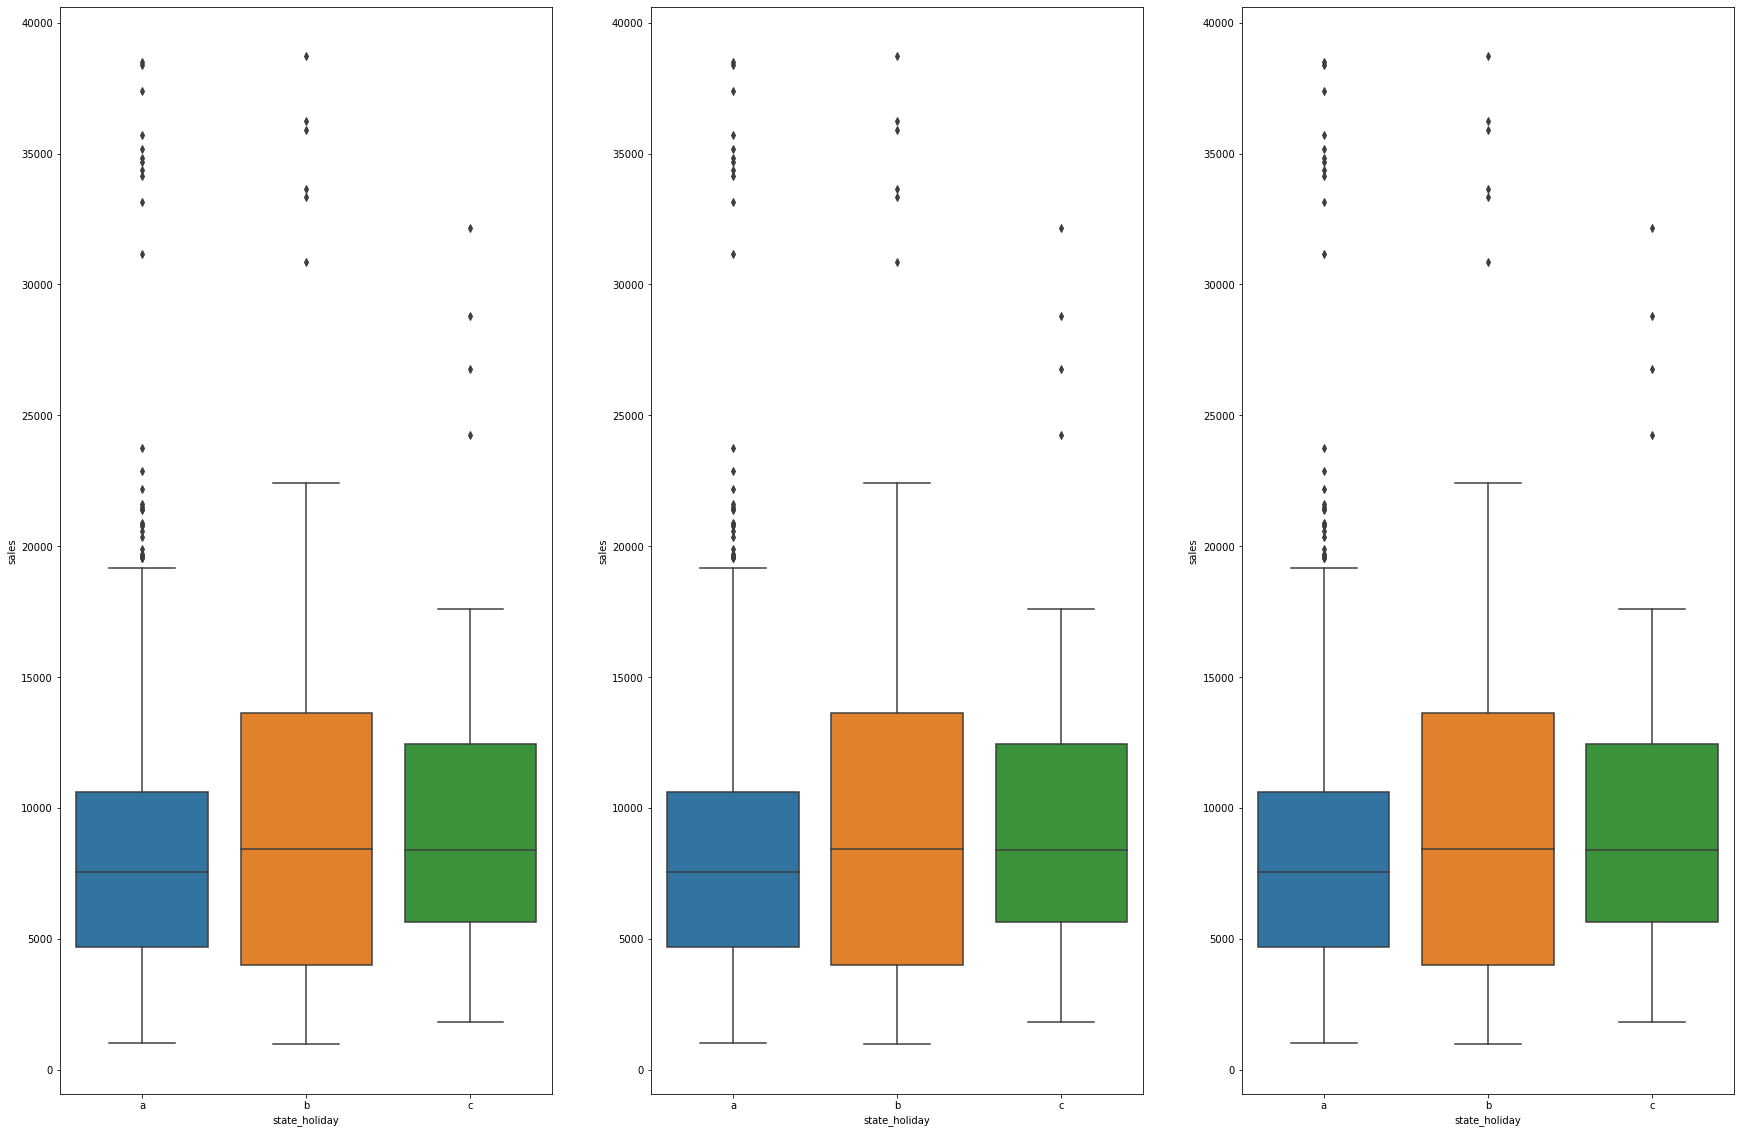

In [23]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'state_holiday',y = 'sales', data = aux1 )

In [24]:
# Descrevendo o boxplot
## A barra mais embaixo significa o menor valor da coluna, enquanto a barra em cima é o maior valor
## No quadrado, o canto inferior é o valor na posição de número 25 enquanto a linha do meio é o 50 e a parte superior do
## quadrado é a posição de número 75
## os pontos pretos são os outliners


# Pesquisar mais sobre boxplot 